# Starbucks Capstone Challenge

### Project Overview

The project uses a simulated data about Starbucks customer behaviour based on offers, rewards and customer response implemented using a mobile app. Accordingly, Starbucks sends out every few days offers to users, which could be a mere advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks, and not all users receive the same offer. The offers have different valididy period

The data to be used in the project is provided in three files, including offer-specific dataset, information on customer profiles and a more detailed dataset listing the various offers, customer responses, awards, and trasactions performed by clients. The transactional data in partcular provides a lot of insights into customer behaviour including the the timestamp of purchase, the amount of money spent on a purchase, a record for each offer recieved by each custormer, when a customer viewed the offer and also information about offer completion by the user. 

### Problem Statement

The main goal of the exercise is to investigate to what extent promotional rewards and discount would influence more spending by Starbucks customers. Thus, the issues we want to address below is to assess the effectiveness of the promotional offers.

### Metrics

We will use the selected model’s accuracy score as the the first measure of predictive power of the selected models.
Secondly, we will extract the feature_importance estimates from the RandomForestModel and try to assess the top 5 most important predictors of completing the offers.

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
# read in the json files containing the datasets
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records',lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Exploration

#### The **portfolio** dataset

In [4]:
# check the full data contained by the portfolio dataset
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
# check for null values in the portfolio dataset
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

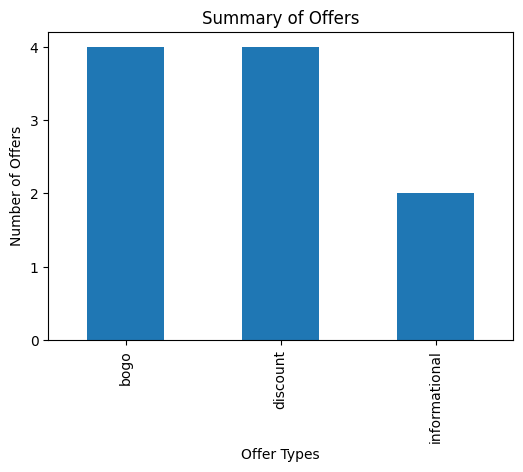

In [6]:
portfolio.groupby('offer_type')['id'].count().plot(kind='bar',title='Summary of Offers',
               ylabel='Number of Offers', yticks=[0,1,2,3,4], xlabel='Offer Types', figsize=(6, 4));

#### The **profile** dataset

In [7]:
# view the first few lines of the dataset
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
# check for null values in the profile dataset
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

The gender and income features have equal 2175 missing values

In [9]:
# check for duplicated rows
profile[profile.duplicated()]

,gender,age,id,became_member_on,income


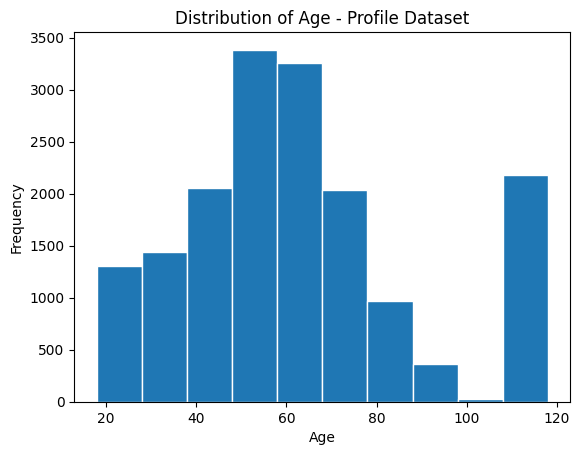

In [10]:
# plot a histogram of age distribution 
profile.age.plot.hist(xlabel='Age',edgecolor='white', title='Distribution of Age - Profile Dataset'); 

Above, we observe a large number of observations who reported age above 110 years.
It is very likely there is a problem with this data.

In [11]:
# As we see below, the problem arises from 2175 observations which reported age of customers equal to 118 years.
profile.groupby('age')['age'].count().tail(10)

age
93       29
94       33
95       22
96        8
97       13
98        5
99        5
100      12
101       5
118    2175
Name: age, dtype: int64

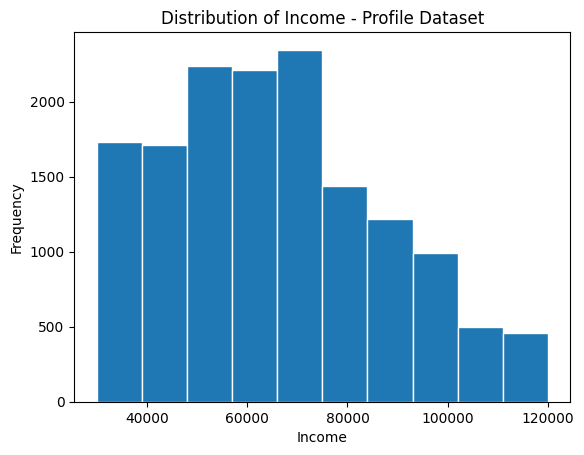

In [12]:
# plot a histogram of the income data to observe its distribution
profile.income.plot.hist(xlabel='Income',edgecolor='white', title='Distribution of Income - Profile Dataset');

In [13]:
# check data associated with reported age of 118 years.
profile[profile['age']== 118].groupby('id').count().sum()

gender                 0
age                 2175
became_member_on    2175
income                 0
dtype: int64

The income and gender columns corresponding to age value of 118 is empty (nan) 

#### The **transcript** dataset

In [14]:
# check the dimension of the transcript dataset
transcript.shape

(306534, 4)

In [15]:
# view the first 5 lines of transcript
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [16]:
# check for null values in the transcript dataset
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [17]:
# tally the frequency of offer types under the 'event' column
transcript['event'].value_counts()/len(transcript)

event
transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: count, dtype: float64

45 percent of the entries in the transcript dataset represent transactions data, 25 percent offer-received, 18 percent offer-viewed
with the remaining 18 percent constituting data of offers completed

In [18]:
# The following code is to inspect the events associated with a casually selected customer 
transcript[transcript.person == 'f3e801caeafe4899b3b989b586e74ac7'].groupby('event').count()

,person,value,time
event,,,
offer completed,5,5,5
offer received,6,6,6
offer viewed,3,3,3
transaction,13,13,13


### Data Processing

- ##### Portfolio dataset

In [19]:
def folio_cleaned(df):
    '''
    This function works on the portfolio dataset primarily to feature-engineer new columns based on one-hot encoding, and
    undertaking linear transformations

    INPUT: 
        df (dataframe): the original portfolio  dataset
    OUTPUT:
        folio (dataframe): an expanded and modified portfolio dataset

    '''
    # create a copy of the porfolio dataset
    folio = df.copy(deep=True)
    # create dummy variable from the 'channels' column
    folio = folio.join(folio.pop('channels').str.join('|').str.get_dummies())
    # convert offer_type into dummies through  one_hot encoding
    folio = pd.get_dummies(folio, columns=['offer_type'], dtype=int, prefix="", prefix_sep="")
    # create a 'durations_in_hrs' variable by multiplying the number of days in the 'duration' column by 24
    folio['duration_in_hrs'] = folio['duration'].apply(lambda x: x *24)
    # rename the 'id' column into 'offer_id'
    folio = folio.rename(columns={'id':'offer_id'})
    
    return folio

- #### Profile dataset

In [20]:
def prof_cleaned(df):
    '''
    The prof_cleaned function focuses on preparing the ground for featuring engineering on the 'age', 'income', 'gender', and 
    'become_a_member' columns. Some of the code also enables to remove largely empty rows and rename one features for clarity

    INPUT:
        df (dataframe): the original profile  dataset
    OUTPUT:
        prof (dataframe): an expanded and modified version of the profile dataset

    '''
    
    prof = df.copy(deep=True)

    #creating age_ranges from 'age' column in the profile dataset
    prof['age_range'] = pd.cut(prof['age'], bins=range(10,120,10),right=False, 
                labels=['10s','20s', '30s', '40s', '50s','60s', '70s', '80s', '90s', '100s'])
    #creating income_ranges from the 'income' column in the dataset
    prof['income_range'] = pd.cut(prof['income'], bins=range(30000,130000,10000), right=False, 
                                            labels=['40k', '50k', '60k', '70k','80k', '90k', '100k', '110k', '120k'])
    # drop the 2175 rows with nan values in the gender, age and income columns 
    prof.drop(index = prof[prof['gender'].isnull()].index, inplace = True)
    # convert gender data into dummies through  one_hot encoding
    prof = pd.get_dummies(prof, columns=['gender'], dtype=int, prefix="gender", prefix_sep="_")
    #convert the values in became_member_on column to datetime datatype
    prof['became_member_on'] = prof['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    # create new column for year
    prof['year'] = prof['became_member_on'].apply(lambda x: x.year)
    # create new columns for month
    prof['month'] = prof['became_member_on'].apply(lambda x: x.month)
    # create new columns for the day of the month
    #prof['day'] = prof['became_member_on'].apply(lambda x: x.day)
    prof = prof.rename(columns={'id':'customer_id'})

    #drop the 'age_range' column
    prof = prof.drop('age', axis=1)
    #drop the 'income_range' column
    prof = prof.drop('income', axis=1)

    return prof

- #### Transcript dataset

In [21]:
def script_cleaned(df):
    ''' 
    The main purpose of this function is to extract the information packed in the 'value' column of the transcripts dataset.
    Since, the data type of the 'value' column is a dictionary, we apply list comprehensivion to extract key_value pairs from the 
    dict_values. In addition to the feature-engineering mentioned above, the function also separates 'offers' and 'transactions' data.

    INPUT:
        df (dataframe): the original transcript dataset
    OUTPUT: 
        offers_only (dataframe): offers_only data extracted from the transcript dataset
        transaction (dataframe): transactions_only data extracted from the transcript dataset
    '''

    # make a copy of the transcript dataset
    script = df.copy(deep=True)
    # create a new 'offer_id' column from the information contained in the 'value' column
    script['offer_id'] = [[*val.values()][0] if [*val.keys()][0] in ['offer id', 'offer_id'] else None for val in script.value]
    # create a new 'amount' column from the information contained in the dictionary values of the 'value' column
    script['amount'] = [[*val.values()][0] if [*val.keys()][0] in ['amount'] else None for val in script.value]
    # rename the 'person' column to 'customer_id'
    script = script.rename(columns={'person': 'customer_id'})
    # drop the 'value' column since all the data in the column is transferred to the 'offer_id' and 'amount' features
    script = script.drop('value', axis=1)
    # create a dataframe from the 'event' column consisting of non-transaction entries
    offers_only = script[script['event'] != 'transaction']
    # create a dataframe holding transactions-only entries
    transaction = script[script['event'] == 'transaction']
    # convert 'offer_types' into dummies using  one_hot encoding
    offers_only = pd.get_dummies(offers_only, columns=['event'], prefix="",  prefix_sep="", dtype=int)

    return offers_only, transaction

### Preparing the Data

In the following section, we will implement additional data preparation steps. We begin by generating the cleaned datasets associated with the three original datasets, combining the three datasets, and applying filtering tasks on the merged data. After saving the filtered data to a file (csv), we will load the data into a Pandas dataframe and apply one final round of processing aimed at handling missing values and implementing feature engineering. 

In [22]:
# apply the folio_cleaned function on the portfolio dataset
portfolio_processed = folio_cleaned(portfolio)

In [23]:
# apply the pro_cleaned fucntion on the profile dataset
profile_processed = prof_cleaned(profile)

In [24]:
# apply the script_cleaned function on the transcript dataset
offers_processed, transactions_processed = script_cleaned(transcript)

In [25]:
def filter_and_combine_data(portfolio, profiles, offers, transactions):

    '''
    This function filters the data contained in the portfolio, profile and transcript datasets and generates combined dataset
    INPUT: 
        portfolio (dataframe): a processed portfolio dataframe generated above
        profiles (dataframe): a processed profiles dataframe generated above
        offers (dataframe): a processed offers only dataframe generated above
        transactions (dataframe): a processed transactions-only dataframe generated above
    OUTPUT: 
        combined_data (dataframe): a merged dataframe generated by applying further filtering on the four input datasets

    '''
    
    # initialize an empty array to store the combined data
    combined_data = []
    # extract all unique customer IDs from the offers dataframe
    customer_ids = offers['customer_id'].unique().tolist()

    for idx in range(len(customer_ids)):
        cs_id = customer_ids[idx]
        # from the profile dataset, select the data of the customer associated with the customer_id
        prof_data = profiles[profiles['customer_id']==cs_id]
        # from the offers dataset, select entries associated with the customer_id
        cs_offer_data = offers[offers['customer_id']==cs_id]
        # from the transactions dataset, select entries associated with the customer_id
        cs_transaction_actual = transactions[transactions['customer_id']==cs_id]

        # retrieve and store data on offer recieved, completed and viewed in separate dataframes
        offer_received_actual = cs_offer_data[cs_offer_data['offer received'] == 1]
        offer_viewed_actual = cs_offer_data[cs_offer_data['offer viewed'] == 1]
        offer_completed_actual = cs_offer_data[cs_offer_data['offer completed'] == 1]

        # initialize an empty list to store filtered offer data for each customer
        collect_entries = []
        # iterate through the offer recieved entries for each customer extraced above
        for i in range(offer_received_actual.shape[0]):
            # identify and select the offer_id
            offer_id = offer_received_actual.iloc[i]['offer_id']
            # from the portfolio dataset, select the specific features of the offer
            offer_type = portfolio.loc[portfolio['offer_id'] == offer_id]
            # from the offer info, extract information on the duration
            duration_days = offer_type['duration'].values[0]
            # calculate duration in hours
            duration_hours = offer_type['duration_in_hrs'].values[0]
            # next, extract the time information from the offer_recieved
            start_time = offer_received_actual.iloc[i]['time']
            # calculate end_time for the offer by adding start_time to the offer duration
            end_time = start_time + duration_hours
            # initialize a boolean array to identify offers viewed within the offers' durations
            offer_viewed_within_duration = np.logical_and(
                offer_viewed_actual['time'] >= start_time, offer_viewed_actual['time'] <=end_time)

            # a boolean array to identify offers completed within the offers' durations
            offer_completed_within_duration = np.logical_and(
                offer_completed_actual['time'] >= start_time, offer_completed_actual['time'] <= end_time)
            # identify the offers viewed and completed within the offer time
            offers_viewed_and_completed = offer_viewed_within_duration.sum() > 0 and offer_completed_within_duration.sum() > 0
            # a boolean array to identify transactions excuted within the offers' durations
            transactions_in_duration = np.logical_and(
                cs_transaction_actual['time'] >= start_time, cs_transaction_actual['time'] <= end_time)
            # extract transaction data undertaken within offer validity period
            transaction_data = cs_transaction_actual[transactions_in_duration]
            # calculate total amount spent by a client from given offers
            transaction_total_amount = transaction_data['amount'].sum()

            # intialize a dictionary template to be filled with each completed offer and transaction data
            filtered_entries = {'offer_id': offer_id, 'customer_id': cs_id,
                                'time': start_time,'total_amount': transaction_total_amount,
                                'offer_completed': int(offers_viewed_and_completed)}
                                
            # update the filtered_entries dictionary with information of customer data contained in the profile dataframe 
            filtered_entries.update(prof_data[prof_data['customer_id'] == cs_id].squeeze().to_dict())
            # update the filtered_entries dictionary with information of offer_id data contained in the offer_types
            filtered_entries.update(offer_type[offer_type['offer_id'] == offer_id].squeeze().to_dict())
            # update the collect_entries dictionary with the information contained in the filtered_entries dictionary 
            collect_entries.append(filtered_entries)
        # add the collect_entries dictionary into the combined data list
        combined_data.extend(collect_entries)

    # convert the combined_data list into a dataframe
    combined_data = pd.DataFrame(combined_data)
    
    return combined_data

In [26]:
# code to generate a processed and combined data by employing the filter_and_combine_data function
processed_data = filter_and_combine_data(portfolio_processed, profile_processed, offers_processed, transactions_processed)

In [27]:
# save the processed dataframe as a file in a csv format
processed_data.to_csv('processed_data.csv', index=False)


In [3]:
def data_refining():
    '''
    This function loads the cleaned data and undertakes additional processing. Main tasks are to remove rows with empty values
    in the age_range, income_range columns. A second main action is to use one-hot encoding to feature-engineer new explanatory
    varialbe out of the income_range, age_range and year columns.

    OUTPUT: 
        final_clean_data (dataframe): a dataframe generated by applying futher refinement on the saved csv file. 

    '''
    # load the processed cvs file into a pandas dataframe
    clean_data = pd.read_csv('processed_data.csv')
    # remove empty rows which currenty only have the string '{}'
    final_clean_data = clean_data[clean_data['age_range'] != '{}']
    # one-hot encode the income_range column
    final_clean_data = pd.get_dummies(final_clean_data, columns=['income_range'], prefix='income',  prefix_sep="_", dtype=int)
    # one-hot encode the age_range column
    final_clean_data = pd.get_dummies(final_clean_data, columns=['age_range'], prefix='age',  prefix_sep="_", dtype=int)
    # one-hot encode the year column
    final_clean_data = pd.get_dummies(final_clean_data, columns=['year'], prefix='year',  prefix_sep="_", dtype=int)
    
    return final_clean_data
    
refined_data = data_refining()


In [4]:
# save the final_data as a csv file
refined_data.to_csv('final_data.csv', index=False)

#### Some analysis based on the combined data

Below, we will calculate the success rates for each of the offer categories. The first step will be to build a function that filters
the number of successfuly completed offers as compared to the total number of offers in each category.

In [5]:
def calculate_offer_success(refined_data, portfolio):
    """ 
    A function to calcualte the success percentage for each offer
    
    INPUT:
        clean_data (dataframe): DataFrame that includes offer_completed along with other offer information
        portfolio (dataframe): The original dataset containing offer_types, duration, etc
    
    OUTPUT:
        percent_success (dataframe): DataFrame that describes the success percentage for each offer
    """

    # group the completed offers by offer_id and aggregate
    success_count = refined_data[['offer_id', 'offer_completed']].groupby('offer_id').sum().reset_index()
    # value counts for the offer_ids
    offer_count = refined_data['offer_id'].value_counts()
    # generate a Pandas dataframe from the indexes and value of the offer_count above
    offer_count = pd.DataFrame(list(zip(offer_count.index.values, offer_count.values)), columns=['offer_id', 'count'])

    # sort the success count data generated above
    sorted_success_count = success_count.sort_values('offer_id')
    # sort the offer_count data
    sorted_offer_count = offer_count.sort_values('offer_id')
    # merge data contained in offer_count and success_count
    offer_success_count = pd.merge(sorted_offer_count, sorted_success_count, on="offer_id")

    # create a success_percent column by dividing offer completed by offer count
    offer_success_count['success_percent'] = (100 * offer_success_count['offer_completed'] / offer_success_count['count'])

    # create a copy of the original porfolio dataset with only the 'id' and 'offer_type' columns included
    portfolio_copy = portfolio[['id', 'offer_type']]
    # rename the 'id' column label to 'offer_id' to facilitate a merge function
    portfolio_copy = portfolio_copy.rename(columns = {'id': 'offer_id'})
    # merge the offer_success_count and portfolio dataframes
    merged_count = pd.merge(offer_success_count, portfolio_copy, on="offer_id")

    # drop the offer_completed column since the desired information is now captured in the new 'success_percent' column
    percent_success = merged_count.drop(columns=['offer_completed'])
    # sort the success percentages 
    percent_success = percent_success.sort_values('success_percent', ascending=False).reset_index(drop=True)

    return percent_success

# apply the calculate_offer_success function to the refined_data and portfolio datasets
offer_success_df = calculate_offer_success(refined_data, portfolio)

In [6]:
# display count and success_percent for each offer_id indicating the preferred offer_types
offer_success_df

,offer_id,count,success_percent,offer_type
0,fafdcd668e3743c1bb461111dcafc2a4,6652,75.285628,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,72.742299,discount
2,f19421c1d4aa40978ebb69ca19b0e20d,6576,61.618005,bogo
3,ae264e3637204a6fb9bb56bc8210ddfd,6683,54.646117,bogo
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,51.721523,bogo
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,48.287210,bogo
6,2906b810c7d4411798c6938adc9daaa5,6631,47.730357,discount
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,45.762712,discount
8,3f207df678b143eea3cee63160fa8bed,6657,7.721196,informational
9,5a8bc65990b245e5a138643cd4eb9837,6643,6.277284,informational


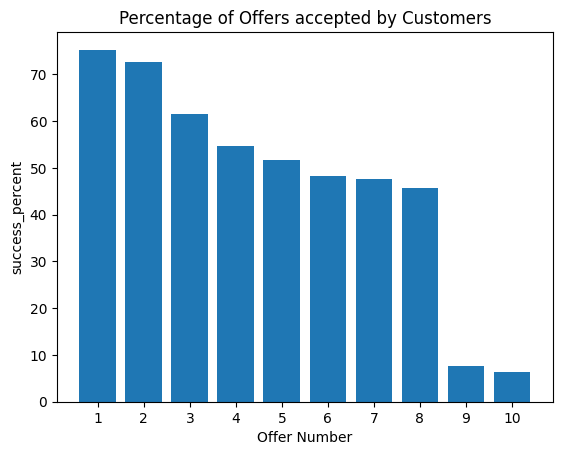

In [7]:
def plot_offer_success(data, column, title):
    """
    This function will plot the offer_success rate generated above
    INPUT:
        df (dataframe): the offer_success dataframe
        column (string): the specific column from the dataframe to be used in the plot
        title (string): A title for the graph
    """
    # x values
    x = data.index + 1
    # y values
    y = data[column]

    # initialize a plot
    plt.bar(x, y)
    plt.xticks(np.arange(1, len(x)+1, 1))
    plt.xlabel('Offer Number')
    plt.ylabel(column)
    plt.title(title)
    plt.show()

# generate the plot by applyin the function to the offer_success dataframe
plot_offer_success(offer_success_df, 'success_percent', 'Percentage of Offers accepted by Customers')

### Split data and scale features

Next we prepare to use ML models to draw insights from the refined data. The first step will be scale selected features.

In [8]:
# initialize a standard scaler object from the sklearn.preprocessing module
scaler = StandardScaler()

In [9]:
# drop columns not needed for the models
final_clean_data_cols_dropped = refined_data.drop(columns=['offer_id', 'time', 'customer_id', 'duration', 'became_member_on'])

In [10]:
# create a list of features to scale
selected_cols = ['total_amount', 'reward', 'difficulty', 'duration_in_hrs']


def scaling_function(df, features):
    
    """
    A function to scale a list of features
    
    INPUT:
        df (dataframe): a dataframe
        features (list): a selected list of columns to apply the scale function

    OUTPUT:
        df_scaled(dataframe): a dataframe recombining back the scaled features with the other variables
    """
        
    # a dataframe formed by extracting the features selected for scaling
    cols_to_scale = df[features]
        
    # apply the scaler's fit_transform method
    scaled_features = pd.DataFrame(scaler.fit_transform(cols_to_scale), columns = cols_to_scale.columns, index=cols_to_scale.index)
        
    # remove the orignal features from the dataframe 
    df = df.drop(columns=features, axis=1)

    # recombine the scaled features with the input dataframe
    df_scaled = pd.concat([df, scaled_features], axis=1)
        
    return df_scaled

# apply the scaler function to the selected columns 
clean_scaled_data = scaling_function(final_clean_data_cols_dropped, selected_cols)

#### Split data into train and test sets

In [11]:
# splitting the dataset

# X includes the independent variables that act as explanaroty variables in the model
X = clean_scaled_data.drop(columns=['offer_completed'])

# y holds data on the feature we will try to predict
y = clean_scaled_data['offer_completed']

# split data into train and test sets using sklearn's train_test_split() method
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Selecting ML Models, Training and Evaluating performance of the models

In the next section, we will use sklearns' ML modules to train selected modesl, fit the training data and test the models on the test sets.

In [12]:
# instantiate a classifier based on sklearn logistic regression model
lrc = LogisticRegression(random_state=42, solver='liblinear')
# initialize another classifier based on the random forest model
rfc = RandomForestClassifier(random_state=42)

In [13]:
def train_model(X_train, y_train):
    """
    This function trains the identified classifers with the X_train and y_train sets
    INPUT:
        X_train (dataframe): the feature variables of the training set
        y_train (Pandas Series): the target variable of the training set
        """
    classifiers = [lrc, rfc]
    for clf in classifiers:
        training = clf.fit(X_train, y_train)
        score = 'Score : {}'.format(clf.score(X_train, y_train))
        print(training)
        print(score + '\n')
 
# run the models based on the training data
train_model(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')
Score : 0.8795488721804511

RandomForestClassifier(random_state=42)
Score : 0.9998066595059076



In [14]:
def evaluate_model_perfomance(X_test, y_test):
    """
    This function tests the identified classifiers with the X_test set
    INPUT:
        X_test (dataframe): featues of the test set
        y_test (Pandas Series): target variable of the test set
        """
    classifiers = [lrc, rfc]
    for clf in classifiers:
        testing = clf.predict(X_test)
        score = 'Test_Score : {}'.format(clf.score(X_test, y_test))
    
        print(clf.__class__.__name__)
        print(score + '\n')
    
# run the evaluate_model function on the test set
evaluate_model_perfomance(X_test, y_test)


LogisticRegression
Test_Score : 0.8793042955240339

RandomForestClassifier
Test_Score : 0.9068718359981955



In [15]:
y_pred_test = rfc.predict(X_test)
matrix = confusion_matrix(y_test, y_pred_test)

In [55]:
matrix

array([[9458, 1042],
       [ 816, 8635]])

### Further Analysis of Results

The logistic regression yielded a predictive accuracy of 87 percent, which is reasonably high. The same data, when applied to a RandomForestClassifier showed an improvement, with 90 percent predictive accuracy.

Next we will assess the features with the greatest explanatory power in the decision to complete the offers.

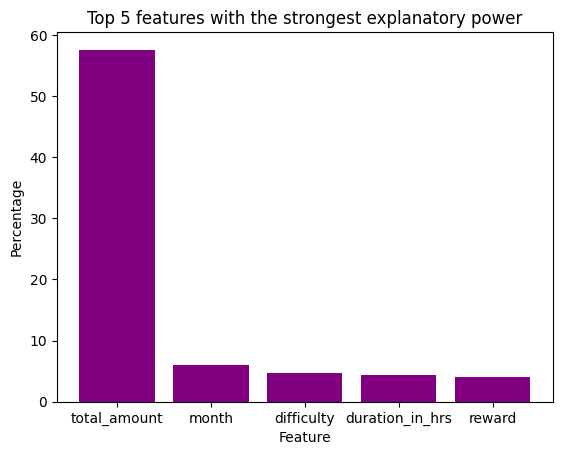

In [16]:
# retrieve the trained parameters from the RandomForestClassifier
explanatory_pwr = pd.DataFrame(rfc.feature_importances_,index=X_train.columns.tolist(),columns=['exp_pwr']).reset_index()
# rename the index
explanatory_pwr.rename(columns={'index': 'feature'}, inplace=True)
# calculate the explanatory power of each variable  
explanatory_pwr['exp_pwr_strength'] = np.round((explanatory_pwr['exp_pwr']/explanatory_pwr['exp_pwr'].sum())*100,2)
# sort the variables
explanatory_pwr = explanatory_pwr.sort_values(by=['exp_pwr_strength'], ascending=False).reset_index(drop=True)
# drop the 'exp_pwr' variable
explanatory_pwr.drop(columns=['exp_pwr'],inplace=True)

# x values
x = explanatory_pwr.loc[0:4, 'feature']
# y values
y = explanatory_pwr.loc[0:4, 'exp_pwr_strength']

# plot the ratios

plt.bar(x, y, color='purple')
plt.xlabel('Feature')
plt.ylabel('Percentage')

plt.title('Top 5 features with the strongest explanatory power')
plt.show()

### Conclusions

 After reviewing the options provided for the Capstone Project, I decided to work on the Starbucks project. I started out by inspecting the three datasets and decided to filter and merge the three sets in order to leverage the related information contained in the different files. My focus was to generate insight that better explains consumers decision on whether to accept and complete offers of discount/GOGO. 
 
 I conducted data cleaning, feature engineering and refinements at several stages. I found that discount offers such as offer 1 and 2 lead to better offer-completion compared to informational offers such as offer 9 and 10. 
 
 Next, I used logistic regression and random forest models. The random forest model yieled the a higher training data accuracy and predictive accuracy compared to the logistic regression. 

Last, I assessed the predictive powers of the features used in the random forest classifier. Based on the strength of each variable's explanatory power, the amount of money the customer spent was the strongest predictor on whether the customer will accept the offer and complete the process.